In [0]:
 # Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [2]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

batch_size = 256
image_dim = 784 #flattened

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.autonotebook import tqdm
from itertools import chain

import numpy as np

class Encoder(nn.Module):
    '''
    simple encoder with a single hidden dense layer
    and linear projections to the diag-Gauss parameters
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        
        mu = self.fc2(out)
        log_sigma2 = self.fc3(out)
        return mu, log_sigma2
      

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, output_dim, hidden_dim, input_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(output_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        
        out = self.fc2(out)
        out = F.sigmoid(out)
        
        return out

In [15]:
import matplotlib.gridspec as gridspec    
import os

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])
    return mu + torch.exp(log_sigma2 / 2) * eps


#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data

        optimizer.zero_grad()

        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        
        kl = 0 
        # kl = D_KL(Q(z|X) || P(z|X)) - calculate in closed form
        # Compute the term kl which is then added to the total loss
        # kl = 0.5 * torch.sum(mu.pow(2) + log_sigma2.exp() - log_sigma2 -1)
        # kl /= inputs.shape[0]
        # kl = (-0.5*torch.sum(-mu.pow(2)-log_sigma2.exp()+1+log_sigma2)) / (batch_size * outputs.size()[1])
        kl = -0.5*torch.mean(1+z[1]-z[0].pow(2)-torch.exp(z[0]))
        loss = recon + kl
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


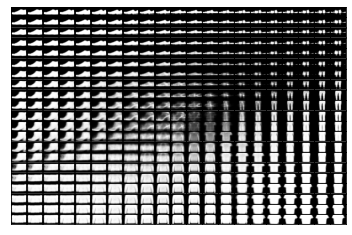

In [25]:
import matplotlib.pyplot as plt
x_points = np.arange(-4, 4, 8/21).astype(np.float32)
y_points = np.arange(4, -4, -8/21).astype(np.float32)

nx, ny = len(x_points), len(y_points)
plt.subplot()
gs = gridspec.GridSpec(nx, ny, hspace=0.05, wspace=0.05)

for i, g in enumerate(gs):
    z = np.concatenate(([x_points[i // ny]], [y_points[int(i % nx)]]))
    # print(z)
    z = torch.tensor(np.reshape(z, (1, 2)))
    x = dec(z)
    ax = plt.subplot(g)
    img = np.array(x.tolist()).reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
plt.show()